# How to Deploy your NLP Model to Production as an API with Algorithmia

- Did you know that 90% of machine learning models never actually make it into production?

- This means that the topic of machine learning deployment is rarely discussed when people learn machine learning. As a result, many AI practitioners know how to create useful ML models, but they find it difficult to deploy them into production.

- Needless to say, machine learning deployment is one of the more important skills you should have if you're going to work with ML models.

***Model deployment is the process of integrating your model into an existing production environment. The model will receive input and predict an output for decision making for a specific use case.***

- For example, a model can be deployed in an e-commerce site and it can predict if a review about a specific product is positive or negative.

- Only when a model is fully integrated with the business systems, we can extract real value from its predictions. - Christopher Samiullah
- There are different ways you can deploy your machine learning model into production. But in today's article, you will learn how to deploy your NLP model into production as an API with Algorithmia.

In [7]:
# import important modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from string import punctuation 

# sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

# text preprocessing modules
from nltk.tokenize import word_tokenize
from cleantext import clean

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import re #regular expression


from wordcloud import WordCloud, STOPWORDS

# Download dependency
for dependency in (
    "brown",
    "names",
    "wordnet",
    "averaged_perceptron_tagger",
    "universal_tagset",
    "stopwords"
):
    nltk.download(dependency)

#nltk.download('stopwords')

import warnings
warnings.filterwarnings("ignore")
# seeding
np.random.seed(123)

[nltk_data] Downloading package brown to /Users/gabe/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package names to /Users/gabe/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.
[nltk_data] Downloading package wordnet to /Users/gabe/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/gabe/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/gabe/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package stopwords to /Users/gabe/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
# load data
data = pd.read_csv("spam.tsv", sep="\t")
# show top five rows
data.head()

,label,message,length,punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2


In [11]:
# check the shape
data.shape

(5572, 4)

### Checking missing values

In [12]:
# check missing values
data.isnull().sum()

label      0
message    0
length     0
punct      0
dtype: int64

### Evaluating Class Distribution

In [13]:
# evalute class distribution
data["label"].value_counts()

label
ham     4825
spam     747
Name: count, dtype: int64

### Exploratory Data Analysis

- In this step we are going to find frequent words that are used in both legitimate and spam messages.

- The above function called collect_words() will collect all words from the dataset according to their labels (ham or spam).

- Then we can visualize frequent words by using the wordcloud Python package. We will start with messages labeled as ham (legitimate).

Total words 349132


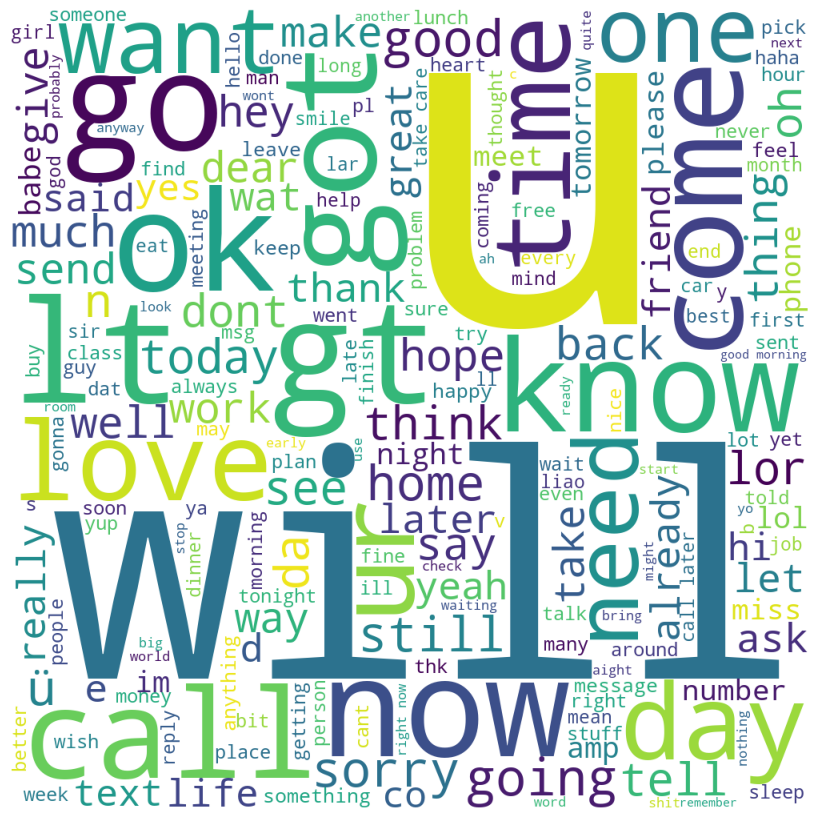

In [18]:
# visualize ham labeled sms
cloud_stopwords = set(STOPWORDS)
ham_words = collect_words(data, label="ham")

print("Total words {}".format(len(ham_words)))

wordcloud = WordCloud(
    width=1000,
    height=1000,
    background_color="white",
    stopwords=cloud_stopwords,
    min_font_size=10,
).generate(ham_words)

# plot the WordCloud image
plt.figure(figsize=(15, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()